In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from imutils import paths
from collections import defaultdict
from tensorflow.keras import layers, models, regularizers, callbacks
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


All images have different sizes and some are on grayscale while others on RGB. We will enforce all of them to be RGB and size 256

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Training",  #directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    seed= 123)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Testing",  # directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    seed=123)

class_names = training_data.class_names
print(class_names)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


Training classes count:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


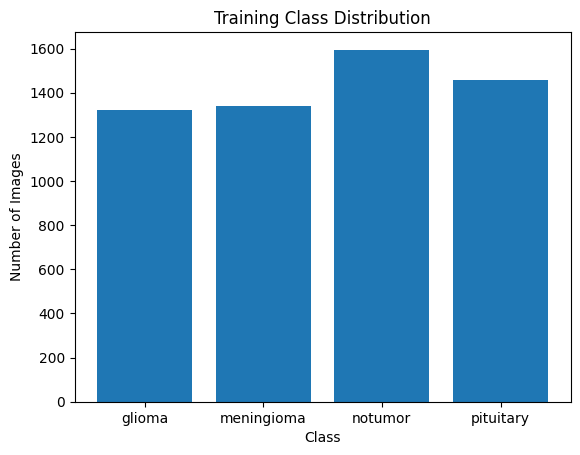

In [3]:
classes = training_data.class_names
class_counts = {name: 0 for name in classes}

for _, labels in training_data:
    for label in labels.numpy():
        class_idx = np.argmax(label) if len(label.shape) > 0 and len(label) > 1 else label
        class_counts[classes[class_idx]] += 1

print("Training classes count:")
print(class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Class Distribution")
plt.show()

Perceptual Hashing to detect and remove duplicates within and between the two datasets.

Following https://pyimagesearch.com/2020/04/20/detect-and-remove-duplicate-images-from-a-dataset-for-deep-learning/

In [4]:

# --- dHash (PyImageSearch-style) ---
def dhash(image, hashSize=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum(2 ** i for i, v in enumerate(diff.flatten()) if v)

# --- Hash all images in a folder; return {hash: [paths,...]} ---
def hash_folder(folder):
    hashes = defaultdict(list)
    for p in paths.list_images(folder):
        # only accept common image extensions
        ext = os.path.splitext(p)[1].lower()
        if ext not in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}:
            continue
        try:
            img = cv2.imread(p)
            if img is None:
                continue
            h = dhash(img)
            hashes[h].append(p)
        except Exception:
            # skip unreadable/corrupt files gracefully
            continue
    return hashes

# --- Remove within-folder duplicates; keep first path in each group ---
def remove_within_duplicates(hashes):
    removed = 0
    for files in hashes.values():
        for dup in files[1:]:
            if os.path.exists(dup):
                os.remove(dup)
                removed += 1
    return removed

# --- Remove cross-duplicates: remove from test any hash also present in train ---
def remove_cross_duplicates(train_hashes, test_hashes):
    removed = 0
    shared = set(train_hashes.keys()) & set(test_hashes.keys())
    for h in shared:
        for p in test_hashes[h]:
            if os.path.exists(p):
                os.remove(p)
                removed += 1
    return removed

def run_duplicate_report(train_folder, test_folder, remove=False):
    # 1) Initial scan
    print(f"[INFO] Scanning {train_folder} and {test_folder}...")
    train_hashes = hash_folder(train_folder)
    test_hashes  = hash_folder(test_folder)

    # counts BEFORE removal
    train_dupes_before = sum(len(v)-1 for v in train_hashes.values() if len(v) > 1)
    test_dupes_before  = sum(len(v)-1 for v in test_hashes.values()  if len(v) > 1)
    cross_before = sum(min(len(train_hashes[h]), len(test_hashes[h])) for h in (set(train_hashes) & set(test_hashes)))

    print("\n[SUMMARY BEFORE REMOVAL]")
    print(f"→ Duplicates in {train_folder}: {train_dupes_before}")
    print(f"→ Duplicates in {test_folder}: {test_dupes_before}")
    print(f"→ Duplicates between both: {cross_before}")

    if not remove:
        return

    # 2) Remove within-set duplicates
    removed_train_within = remove_within_duplicates(train_hashes)
    removed_test_within  = remove_within_duplicates(test_hashes)

    # 3) Re-scan after within-set removals
    train_hashes = hash_folder(train_folder)
    test_hashes  = hash_folder(test_folder)

    # 4) Remove cross-duplicates (from test if present in train)
    removed_cross = remove_cross_duplicates(train_hashes, test_hashes)

    # 5) Final scan for report
    train_hashes = hash_folder(train_folder)
    test_hashes  = hash_folder(test_folder)
    train_dupes_after = sum(len(v)-1 for v in train_hashes.values() if len(v) > 1)
    test_dupes_after  = sum(len(v)-1 for v in test_hashes.values()  if len(v) > 1)
    cross_after = sum(min(len(train_hashes[h]), len(test_hashes[h])) for h in (set(train_hashes) & set(test_hashes)))

    print("\n[REMOVAL SUMMARY]")
    print(f"Removed within {train_folder}: {removed_train_within}")
    print(f"Removed within {test_folder}: {removed_test_within}")
    print(f"Removed cross-duplicates from {test_folder}: {removed_cross}")

    print("\n[SUMMARY AFTER REMOVAL]")
    print(f"→ Duplicates in {train_folder}: {train_dupes_after}")
    print(f"→ Duplicates in {test_folder}: {test_dupes_after}")
    print(f"→ Duplicates between both: {cross_after}")

# ---- Run exactly once (choose ONE of these) ----
run_duplicate_report("data/Training", "data/Testing", remove=True)

[INFO] Scanning data/Training and data/Testing...

[SUMMARY BEFORE REMOVAL]
→ Duplicates in data/Training: 303
→ Duplicates in data/Testing: 42
→ Duplicates between both: 281

[REMOVAL SUMMARY]
Removed within data/Training: 303
Removed within data/Testing: 42
Removed cross-duplicates from data/Testing: 253

[SUMMARY AFTER REMOVAL]
→ Duplicates in data/Training: 0
→ Duplicates in data/Testing: 0
→ Duplicates between both: 0


In [5]:
unsplit_training_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Training",  #directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False,
    seed= 123)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Testing",  # directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False,
    seed=123)

class_names = training_data.class_names
print(class_names)

Found 5409 files belonging to 4 classes.
Found 1016 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


Training classes count:
{'glioma': 1321, 'meningioma': 1333, 'notumor': 1310, 'pituitary': 1445}


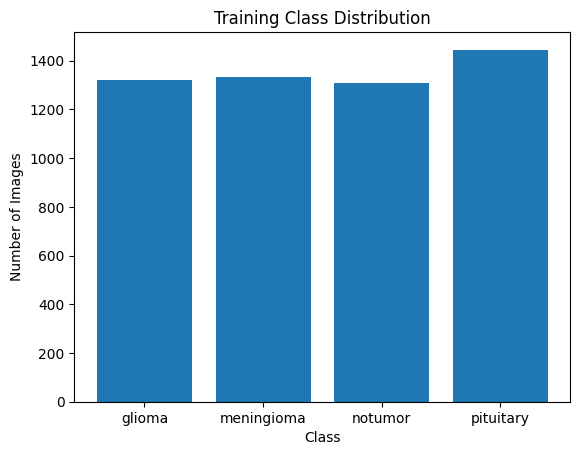

In [6]:
classes = unsplit_training_data.class_names
class_counts = {name: 0 for name in classes}

for _, labels in unsplit_training_data:
    for label in labels.numpy():
        class_idx = np.argmax(label) if len(label.shape) > 0 and len(label) > 1 else label
        class_counts[classes[class_idx]] += 1

print("Training classes count:")
print(class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Class Distribution")
plt.show()

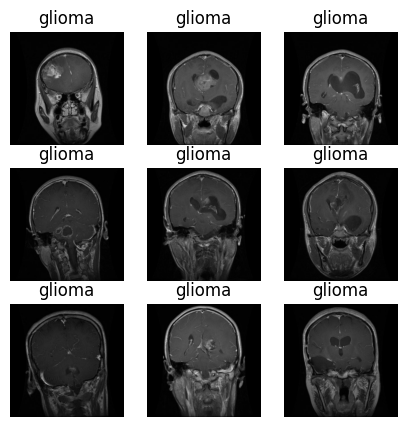

In [7]:

plt.figure(figsize=(5, 5)) # to set the figure size
for image_batch, labels_batch in unsplit_training_data.take(1): 
    for i in range(9):
        plt.subplot(3, 3, i + 1) # 3 rows, 3 columns, i+1 is the index
        plt.imshow(image_batch[i].numpy().astype("uint8")) # imshow expects a numpy 3D array
        plt.axis("off")
        plt.title(class_names[labels_batch[i]]) # to add the label

# note by default tf.keras.preprocessing.image_dataset_from_directory() will shuffle the data 
# so you get a different image each time you run the cell

In [8]:
os.environ["PYTHONHASHSEED"] = str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

def split_train_val(data_dir, img_size=(256, 256), batch_size=32, seed=123, val_split=0.2):
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int",
        shuffle=False,
    )
    return train_data, val_data

train_data, val_data = split_train_val("data/Training")
print(len(train_data), 'batches' , len(val_data), 'batches', len(test_data), 'batches')

Found 5409 files belonging to 4 classes.
Using 4328 files for training.
Found 5409 files belonging to 4 classes.
Using 1081 files for validation.
136 batches 34 batches 32 batches


In [9]:
for images, labels in train_data.take(1):
    print(type(images))  
    print(type(labels))   
    print(images.shape)   
    print(labels.shape)   

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 256, 3)
(32,)


Each data is a tuple containing the image as a 4D tensor (32, 256, 256, 3) and its label as a 1D tensor (32,) which contains labels from 0-3

In [10]:
# to speed up training, cache the dataset and prefetch batches. Add shuffle to the training data 

train_data = train_data.shuffle(1000, seed=123).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### Data Preprocessing 

In [11]:
# Rescaling (256x256=> divide by 255 so that pixel values are between 0 and 1)

resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(256, 256), # adding a resize layer to the model to ensure all images in prediction follow same size
    layers.Rescaling(1.0/255)  # a rescaling layer to normalize pixel values
])

# data augmentation layers: add horizontal flip, random rotation and zoom 
# to generate new samples so that the model can still predict well if image is flipped or rotated



data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=123),   
    layers.RandomRotation(0.05, seed=123),       
    layers.RandomZoom(0.10, seed=123),           
    layers.RandomTranslation(0.05, 0.05, seed=123),  
    layers.RandomContrast(0.10, seed=123),       
])


In [12]:
def cnn_model(l2w=1e-4, drop=0.4):
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(drop),
        layers.Dense(4, activation='softmax'),

    ])

    return model

model = cnn_model()

model.build((32, 256, 256, 3))  # model with input shape batch_size 32, height 256, width 256, and 3 color channels
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 64, 64, 32)          0         
 g2D)                                                 

In [13]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  
os.environ["PYTHONHASHSEED"] = str(123)


SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    verbose=1
)


Epoch 1/30
136/136 [==============================] - 12s 75ms/step - loss: 1.2034 - accuracy: 0.4362 - val_loss: 1.1064 - val_accuracy: 0.2461
Epoch 2/30
136/136 [==============================] - 10s 75ms/step - loss: 0.9125 - accuracy: 0.6222 - val_loss: 0.9992 - val_accuracy: 0.5661
Epoch 3/30
136/136 [==============================] - 10s 74ms/step - loss: 0.7806 - accuracy: 0.6779 - val_loss: 1.5223 - val_accuracy: 0.3626
Epoch 4/30
136/136 [==============================] - 10s 74ms/step - loss: 0.6969 - accuracy: 0.7220 - val_loss: 1.7778 - val_accuracy: 0.3275
Epoch 5/30
136/136 [==============================] - 10s 74ms/step - loss: 0.6512 - accuracy: 0.7274 - val_loss: 0.3890 - val_accuracy: 0.9019
Epoch 6/30
136/136 [==============================] - 10s 74ms/step - loss: 0.5621 - accuracy: 0.7655 - val_loss: 0.7506 - val_accuracy: 0.7391
Epoch 7/30
136/136 [==============================] - 10s 74ms/step - loss: 0.5679 - accuracy: 0.7643 - val_loss: 0.9257 - val_accuracy:

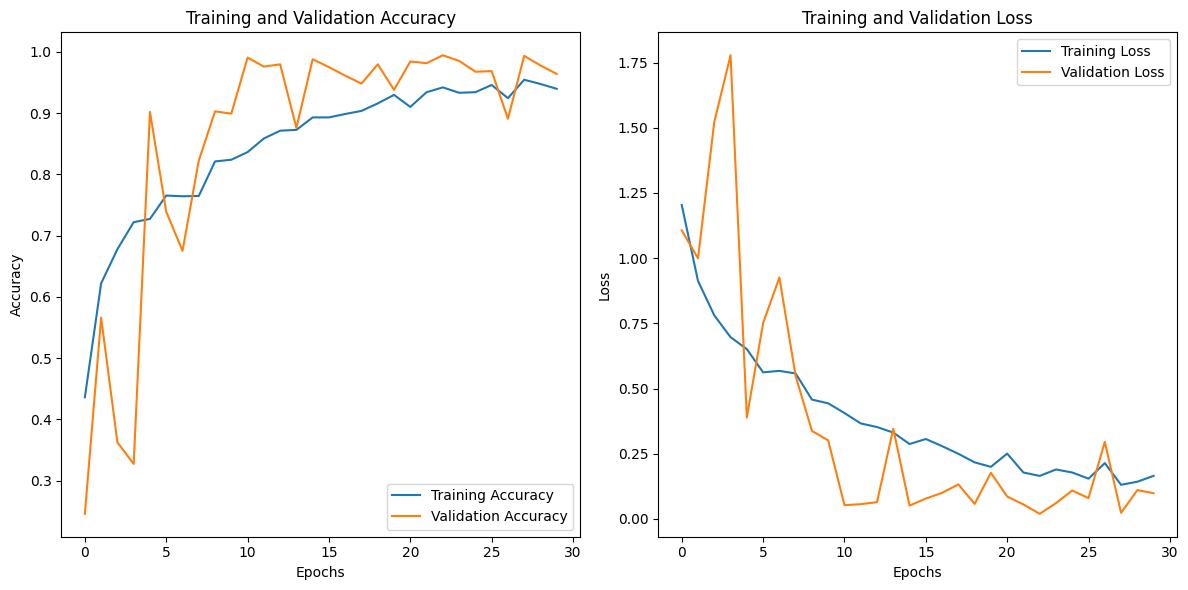

In [14]:
train_acc= history.history['accuracy']
train_loss= history.history['loss']
val_acc= history.history['val_accuracy']
val_loss= history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

In [15]:
scores= model.evaluate(test_data)

32/32 [==============================] - 1s 16ms/step - loss: 0.1705 - accuracy: 0.9567


1/1 [==============================] - 0s 11ms/step


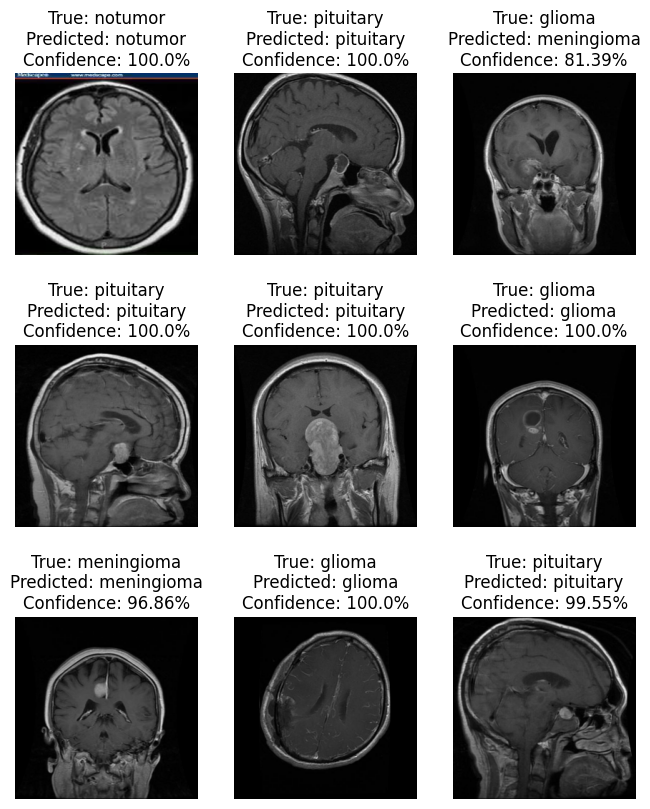

In [16]:
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(image)  
    image_array = tf.expand_dims(image_array, 0)  
    predictions = model.predict(image_array)
    predicted_label = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_label, confidence

shuffled_test_data = test_data.unbatch().shuffle(10000, seed=SEED).take(9).batch(9)

plt.figure(figsize=(8,10))
for image_batch, labels_batch in shuffled_test_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        predicted_label, confidence = predict(model, image_batch[i].numpy())
        true_label = class_names[labels_batch[i]]

        plt.title(f"True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%")
        plt.axis("off")

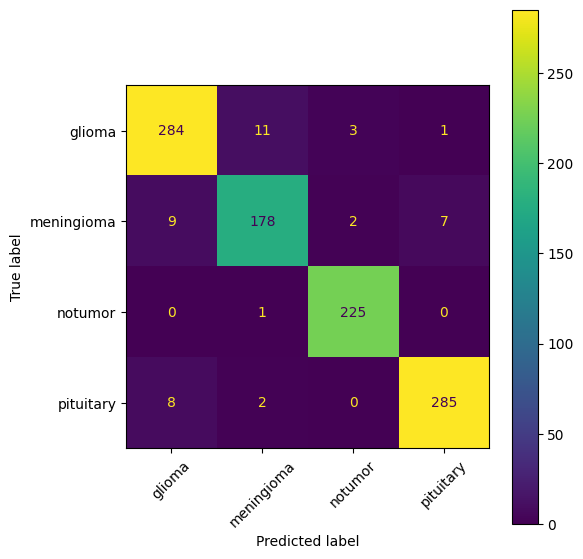

In [17]:
y_true = []
y_pred = []
for xb, yb in test_data.unbatch().batch(64):
    preds = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45)
plt.tight_layout()

In [18]:
model_version = "cnn_brain_tumor_v1.keras"
os.makedirs("models", exist_ok=True)
model.save(f"models/{model_version}")